In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import numpy as np 
import seaborn as sb
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator
import scipy
plt.style.use('seaborn')
%matplotlib inline 
sb.set_style('darkgrid')

In [2]:
base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

def string_to_date(input_):
    """Converts string of type 01/22/02 [for 22 Jan 2020] into datetime object"""
    # return pd.to_datetime(input_, format='%m/%d/%y', errors='ignore')
    return pd.to_datetime(input_, format='%m/%d/%y')


def set_date_formatting(ax):
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))
    ax.tick_params(axis='x', rotation=90)

# read data from web
#
def fetch_data(names = ['confirmed_global', 'deaths_global', 'recovered_global']):
    """Return 4 data frames:
    [confirmed, deaths, recovered], location_info
    
    where confirmed, deaths and recovered are data frames with countries/regions in the rows, and 
    days in the columns
    
    and location_info provides additional information about the locations.
    
    We assume all three tables have the same entries"""
    location_info = pd.DataFrame()
    dfs = []
    for name in names:
        url = os.path.join(base_url, "time_series_covid19_" + name + ".csv")
        df = pd.read_csv(url, index_col=1)
    
        
        df = df.drop(labels=["Lat", "Long", "Province/State"], axis=1)
        #df = df.drop(labels=["Lat", "Long"], axis=1)
        
        # extract dates from strings
        dates = string_to_date(df.columns[1:])        
        # use those objects as new column labels
        df.columns = [df.columns[0]] + list(dates)
        print(f"{name:10}: last data point from {max(dates[1:])}")
        # dfs.append([df, location_info)
        dfs.append(df)

    return dfs

In [3]:
confirmed, deaths, recovered = fetch_data()

confirmed_df = confirmed
deaths_df = deaths
recoveries_df = recovered

confirmed_global: last data point from 2020-03-26 00:00:00
deaths_global: last data point from 2020-03-26 00:00:00
recovered_global: last data point from 2020-03-26 00:00:00


In [24]:
#confirmed_df.head()
columns = confirmed_df.keys()
confirmed = confirmed_df.loc[:, columns[2]:columns[-1]]
deaths = deaths_df.loc[:, columns[2]:columns[-1]]
recoveries = recoveries_df.loc[:, columns[2]:columns[-1]]

In [6]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
total_recovered = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    mortality_rate.append(death_sum/confirmed_sum)
    total_recovered.append(recovered_sum)
days_since_1_23 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [7]:
days_in_future = 15
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-15]

In [8]:
start = '1/24/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [9]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_23, world_cases, test_size=0.15, shuffle=False) 

# SVM Fitting

In [11]:
kernel = ['poly', 'sigmoid', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel': kernel, 'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
svm_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 113 out of 120 | elapsed:    8.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   43.8s finished
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=40, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'kernel': ['poly', 'sigmoid', 'rbf'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [12]:
svm_search.best_params_

{'shrinking': True, 'kernel': 'poly', 'gamma': 0.1, 'epsilon': 1, 'C': 0.01}

In [13]:
svm_confirmed = svm_search.best_estimator_
svm_pred = svm_confirmed.predict(future_forcast)

#### checking against testing data
#svm_test_pred = svm_confirmed.predict(X_test_confirmed)
#plt.plot(svm_test_pred)
#plt.plot(y_test_confirmed)
#print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
#print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


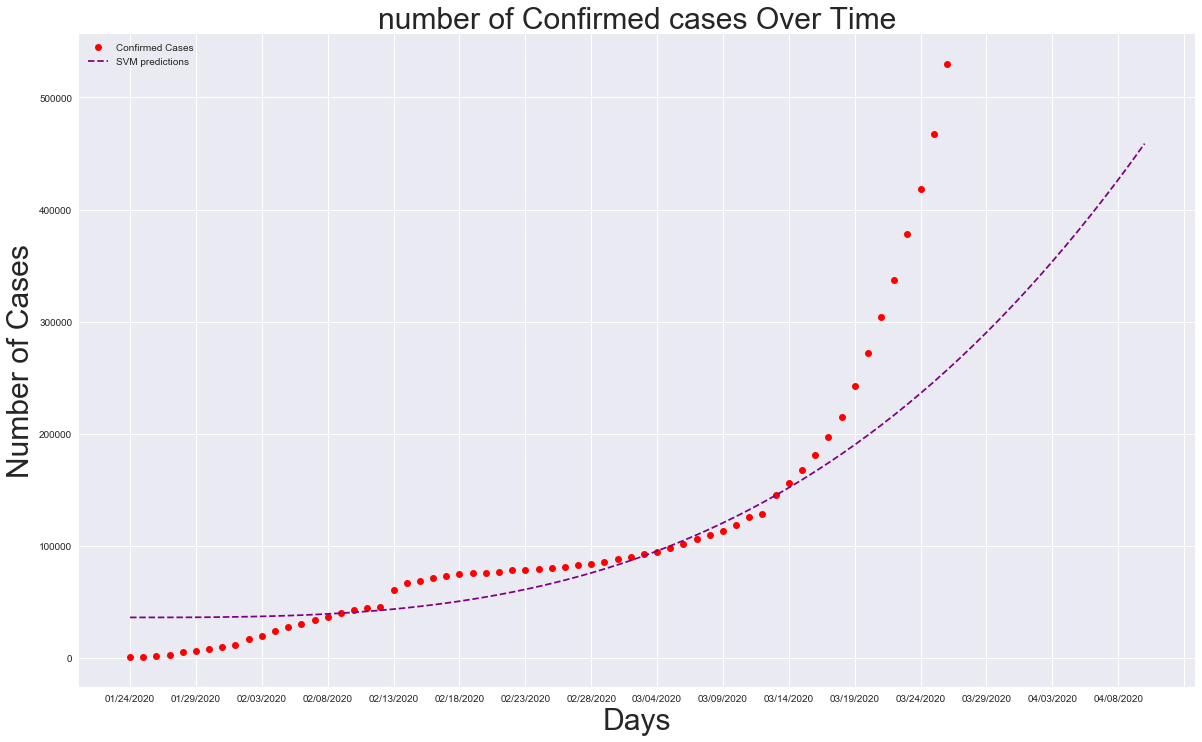

In [14]:
import matplotlib.ticker as ticker

plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases,'ro')
plt.plot(future_forcast_dates, svm_pred, linestyle='dashed', color='purple')
plt.title('number of Confirmed cases Over Time', size=30)
plt.xlabel('Days', size=30)
plt.ylabel('Number of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM predictions'], loc = 'upper left')
#plt.xticks(size=50)
#plt.xticks(np.arange(svm_pred.size), future_forcast_dates[1:], rotation=15,size = 15)
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.show()

In [15]:
# Future predictions using SVM 
print('Future predictions using SVM :')
SV = pd.DataFrame(svm_pred[-15:],future_forcast_dates[-15:])
SV.rename(columns={0: "Infected/Confirmed"}, inplace = True)
SV

Future predictions using SVM :


,Infected/Confirmed
03/27/2020,267695.659218
03/28/2020,278887.350841
03/29/2020,290434.304892
03/30/2020,302342.072345
03/31/2020,314616.204176
04/01/2020,327262.251361
04/02/2020,340285.764875
04/03/2020,353692.295693
04/04/2020,367487.394791
04/05/2020,381676.613144


# Linear Regression

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


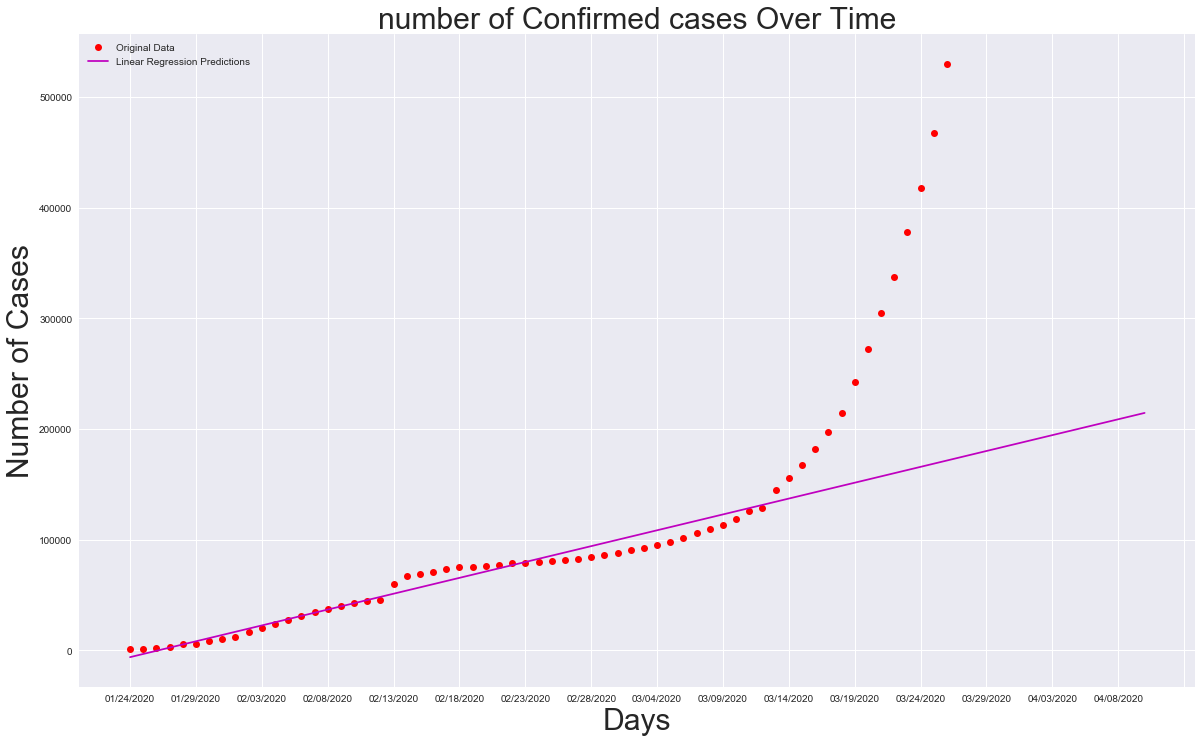

In [16]:
import operator

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(X_train_confirmed)

model = LinearRegression()
model.fit(X_train_confirmed, y_train_confirmed)
y_poly_pred = model.predict(future_forcast)

plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases,'ro',label = "Original Data")
plt.title('number of Confirmed cases Over Time', size=30)
plt.xlabel('Days', size=30)
plt.ylabel('Number of Cases', size=30)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(future_forcast,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(future_forcast_dates, y_poly_pred, color='m', label="Linear Regression Predictions")
plt.legend(loc = 'upper left')
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.show()


In [17]:
print("Future predictions using logistic regression:")
Linreg = pd.DataFrame(y_poly_pred[-15:],future_forcast_dates[-15:])
Linreg.rename(columns={0: "Infected/Confirmed"}, inplace = True)
Linreg

Future predictions using logistic regression:


,Infected/Confirmed
03/27/2020,174447.383890
03/28/2020,177312.168360
03/29/2020,180176.952830
03/30/2020,183041.737300
03/31/2020,185906.521771
04/01/2020,188771.306241
04/02/2020,191636.090711
04/03/2020,194500.875181
04/04/2020,197365.659652
04/05/2020,200230.444122


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


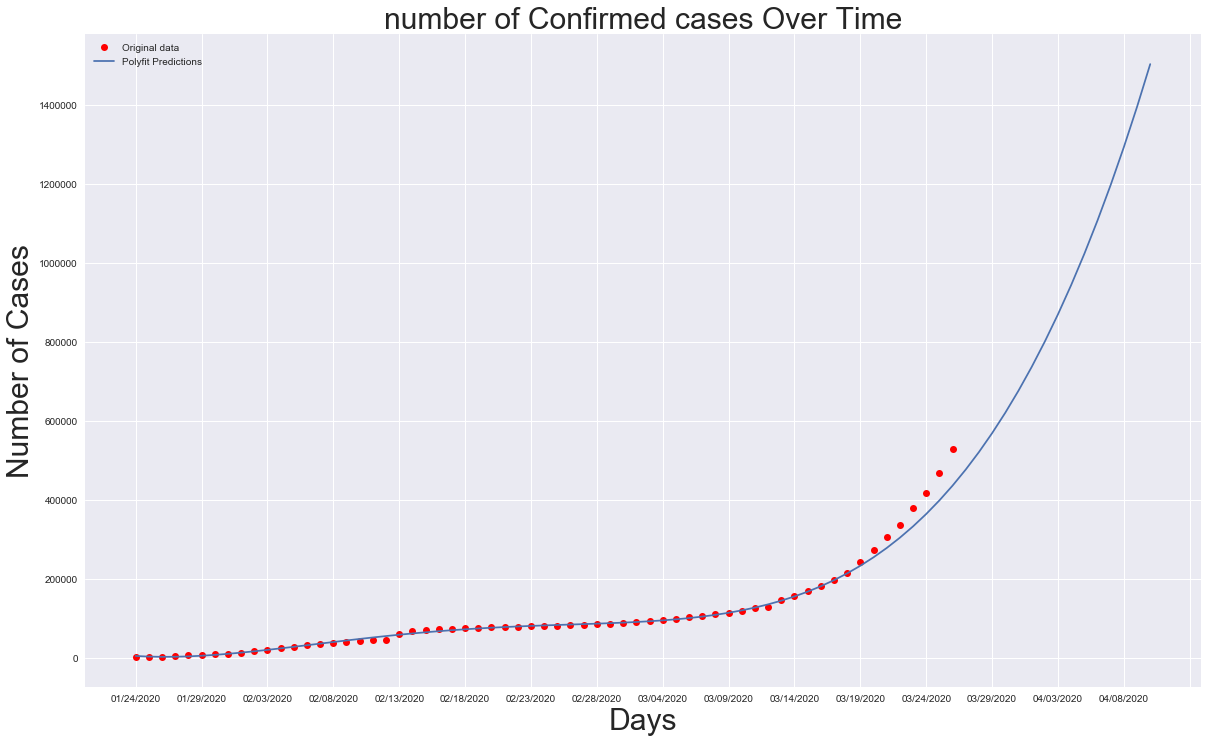

In [18]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

import operator
import numpy.polynomial.polynomial as poly
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures


coefs = poly.polyfit(X_train_confirmed.ravel(), y_train_confirmed.ravel(), 4)
ffit = poly.polyval(future_forcast, coefs)
pred = poly.polyval(future_forcast, coefs)


plt.figure(figsize=(20, 12))
#plt.yscale('log',basey=2) ###to visualize minute changes in the plot
plt.plot(adjusted_dates, world_cases,'ro',label="Original data")
plt.plot(future_forcast_dates,pred, label = "Polyfit Predictions")
plt.legend(loc='upper left')
plt.title('number of Confirmed cases Over Time', size=30)
plt.xlabel('Days', size=30)
plt.ylabel('Number of Cases', size=30)

ax = plt.axes()
ay = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

plt.show()

In [19]:
print("Future predictions using Polyfit:")
#da  = np.asarray(future_forcast_dates) 
poly = pd.DataFrame(np.round(pred[-15:]),future_forcast_dates[-15:])
poly.rename(columns={0: "Infected/Confirmed"}, inplace = True)
#poly.apply(lambda x:'%10f'%x, axis =1)
poly

Future predictions using Polyfit:


,Infected/Confirmed
03/27/2020,476570.0
03/28/2020,520824.0
03/29/2020,568737.0
03/30/2020,620502.0
03/31/2020,676319.0
04/01/2020,736389.0
04/02/2020,800920.0
04/03/2020,870125.0
04/04/2020,944219.0
04/05/2020,1023425.0


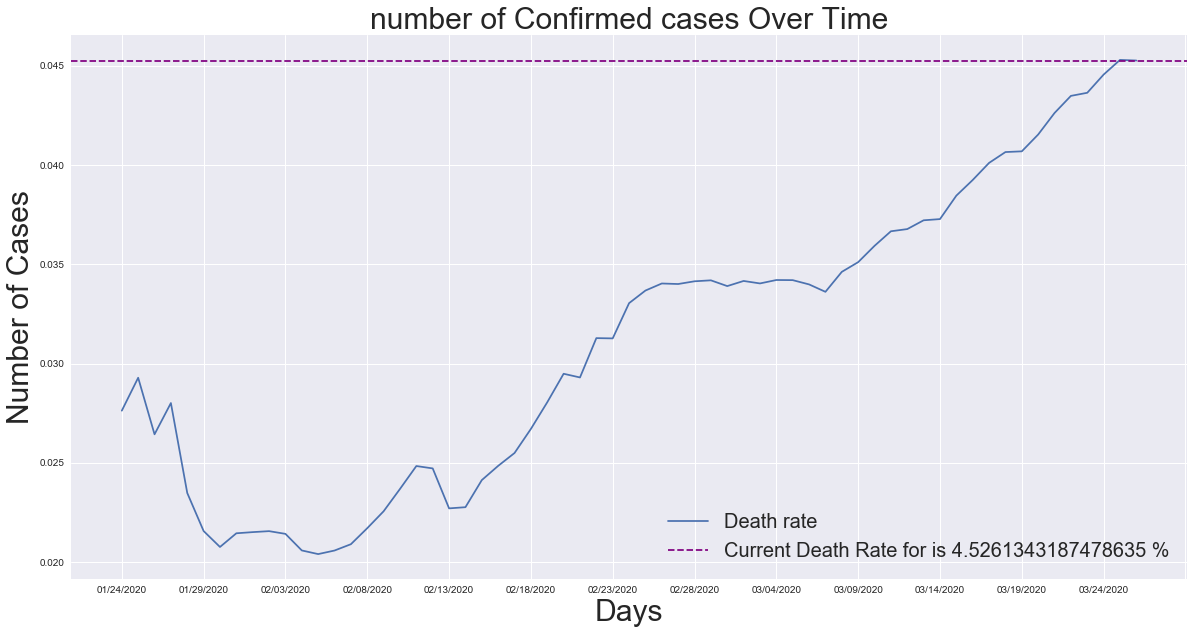

In [20]:
import matplotlib.dates as mdates
import matplotlib

#plt.plot(adjusted_dates, mortality_rate)
figsize = [20,10]
fig, ax = plt.subplots(figsize=figsize)
#set_date_formatting(ax)
plt.plot(future_forcast_dates[0:len(mortality_rate)], mortality_rate)
plt.title('number of Confirmed cases Over Time', size=30)
plt.xlabel('Days', size=30)
plt.ylabel('Number of Cases', size=30)
#ax.set_yscale('log')
curr = mortality_rate[-1]
ax.axhline(y=curr.max(), color='purple', linestyle='--') 
ax.legend(['Death rate','Current Death Rate for is {} %'.format(curr.max()*100)],loc = 'lower right', fontsize = 20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.show()

In [21]:
MX_train_confirmed, MX_test_confirmed, My_train_confirmed, My_test_confirmed = train_test_split(days_since_1_23, mortality_rate, test_size=0.15, shuffle=False) 

In [33]:
coefs = poly.polyfit(MX_train_confirmed.ravel(), My_train_confirmed.ravel(), 4)
ffit = poly.polyval(future_forcast, coefs)
pred = poly.polyval(future_forcast, coefs)

plt.figure(figsize=(20, 12))
#plt.yscale('log',basey=2) ###to visualize minute changes in the plot
plt.plot(adjusted_dates, mortality_rate,'ro',label="Original data")
plt.plot(future_forcast_dates,pred, label = "Polyfit Predictions")
plt.legend(loc='upper left')
plt.title('number of Confirmed cases Over Time', size=30)
plt.xlabel('Days', size=30)
plt.ylabel('Number of Cases', size=30)

ax = plt.axes()
ay = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

plt.show()

AttributeError: 'DataFrame' object has no attribute 'polyfit'

In [114]:
type(X_test_confirmed.ravel())

numpy.ndarray